In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
file_names = os.listdir('./data/database/')

In [3]:
target_size = (400,400)

def read_image(path, target_size = target_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, target_size)

In [4]:
images = [ read_image('./data/database/'+str(path)) for path in file_names ]

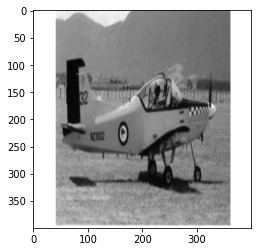

In [5]:
plt.figure()
plt.imshow(images[0], cmap='gray')
plt.show()

## HOG

In [6]:
hog = cv2.HOGDescriptor()

In [7]:
hogs = [ hog.compute(im) for im in images ]

In [8]:
def top_5(name, sorted_indexes, file_names=file_names):
    count = 0
    for img_index in sorted_indexes[:5] :
        if file_names[img_index].startswith(name):
            count+=1
    return count/5

def top_1(name, sorted_indexes, file_names=file_names):
    if file_names[sorted_indexes[0]].startswith(name):
        return 1
    return 0

In [9]:
def calculate_accuracy_hog(database_hogs, distance_function):
    top1 = 0
    top5 = 0
    query_all = []
    sorted_indexes_all = []
    names = ["airplane", "ball", "car", "cat", "dolphin", "face", "lotus", "pickles"]
    for name in names:
        query = read_image('./data/'+str(name)+'_query.jpg')
        query_all.append(query)
        query_hog = hog.compute(query)
        distances = distance_function(database_hogs, query_hog)
        sorted_indexes = np.argsort(distances)
        sorted_indexes_all.append(sorted_indexes)
        top1 += top_1(name, sorted_indexes)
        top5 += top_5(name, sorted_indexes)
    return top1/len(names), top5/len(names), sorted_indexes_all, query_all

In [10]:
def euclidean_distance(database_hogs, query_hog):
    return [np.linalg.norm(database-query_hog) for database in hogs]

def cosine_distance(database_hogs, query_hog):
    return [cosine_similarity(database.reshape(1, -1),query_hog.reshape(1, -1))[0][0] for database in hogs]

def scalar_product(database_hogs, query_hog):
    return [np.dot(database,query_hog) for database in hogs]

def correlation(database_hogs, query_hog):
    return [np.correlate(database,query_hog)[0] for database in hogs]

## pairwise distances ?

In [11]:
top1, top5, sorted_images_all, query_all = calculate_accuracy_hog(hogs, euclidean_distance)

In [12]:
print("Top 1 accuracy is : " + str(top1) + "%")
print("Top 5 accuracy is : " + str(top5) + "%")

Top 1 accuracy is : 0.75%
Top 5 accuracy is : 0.525%


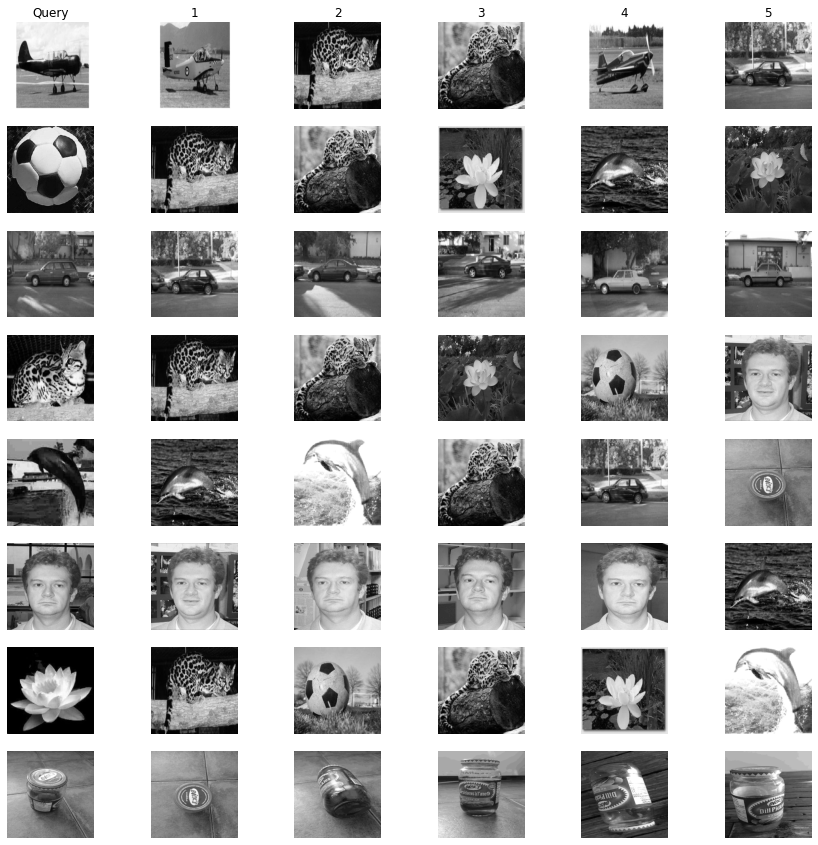

In [13]:
fig = plt.figure(figsize=[15, 15])
rows = 8
columns = 6
current_subplot = 0

for current_row in range(8):
    current_subplot += 1
    fig.add_subplot(rows, columns, current_subplot)
    plt.imshow(query_all[current_row], cmap='gray')
    plt.axis("off")
    if current_row == 0 :
        plt.title("Query")

    for i in range(5):
        current_subplot += 1
        fig.add_subplot(rows, columns, current_subplot)
        plt.imshow(images[sorted_images_all[current_row][i]], cmap='gray')
        plt.axis("off")
        
        if current_row == 0 :
            plt.title(i+1)

## Sift

In [14]:
query1 = read_image('./data/database/airplane_1.jpg')

In [15]:
sift = cv2.SIFT_create()

In [21]:
kp1, des1 = sift.detectAndCompute(query1,None)

In [23]:
des1.shape

(567, 128)

In [25]:
img1 = cv2.drawKeypoints(query1, kp1, query1)

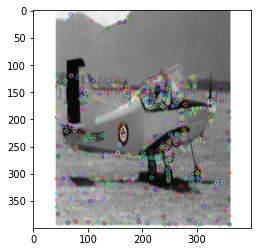

In [27]:
plt.figure()
plt.imshow(img1)
plt.show()

In [28]:
query2 = read_image('./data/airplane_query.jpg')
kp2, des2 = sift.detectAndCompute(query2,None)
des2.shape

(385, 128)

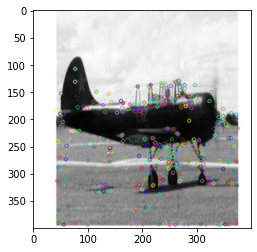

In [31]:
img2 = cv2.drawKeypoints(query2, kp2, query2)
plt.figure()
plt.imshow(img2)
plt.show()

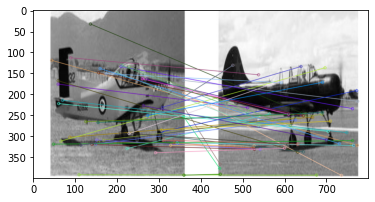

In [32]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(query1, kp1, query2, kp2, matches[:50], query2, flags=2)
plt.imshow(img3)
plt.show()

In [33]:
# The number of matches is an indicator to the similarity i guess
print(len(matches))

92


In [34]:
sift = cv2.SIFT_create()

In [35]:
database_descriptors = [ sift.detectAndCompute(im,None)[1] for im in images ]

In [46]:
def calculate_accuracy_sift(database_desc):
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    top1 = 0
    top5 = 0
    query_all = []
    sorted_indexes_all = []
    names = ["airplane", "ball", "car", "cat", "dolphin", "face", "lotus", "pickles"]
    for name in names:
        query = read_image('./data/'+str(name)+'_query.jpg')
        query_all.append(query)
        query_desc = sift.detectAndCompute(query, None)[1]
        
#         # calcul de similarité, nombre de match opencv
#         distances = [ len(bf.match(query_desc,desc)) for desc in database_desc ]
        
#         # https://adnanmushtaq5.medium.com/sift-algorithm-for-image-comparison-4b17362d521 
#         flann = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict())
#         distances = [ len(flann.knnMatch(query_desc, desc, k=2)) for desc in database_desc ]

        # https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-2-c4350274be2b
        # Pt checker ce lien la pour faire du meilleur matching
        distances = [ len(calculate_matching(query_desc, desc)) for desc in database_desc ]
        
        
        sorted_indexes = np.argsort(distances)[::-1]
        sorted_indexes_all.append(sorted_indexes)
        top1 += top_1(name, sorted_indexes)
        top5 += top_5(name, sorted_indexes)
    return top1/len(names), top5/len(names), sorted_indexes_all, query_all

In [63]:
# https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-2-c4350274be2b
def calculate_matching(desc1, desc2):
    flann = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict())
    matches = flann.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)
    return good

In [64]:
top1, top5, sorted_images_all, query_all = calculate_accuracy_sift(database_descriptors)

In [65]:
print("Top 1 accuracy is : " + str(top1) + "%")
print("Top 5 accuracy is : " + str(top5) + "%")

Top 1 accuracy is : 0.375%
Top 5 accuracy is : 0.425%


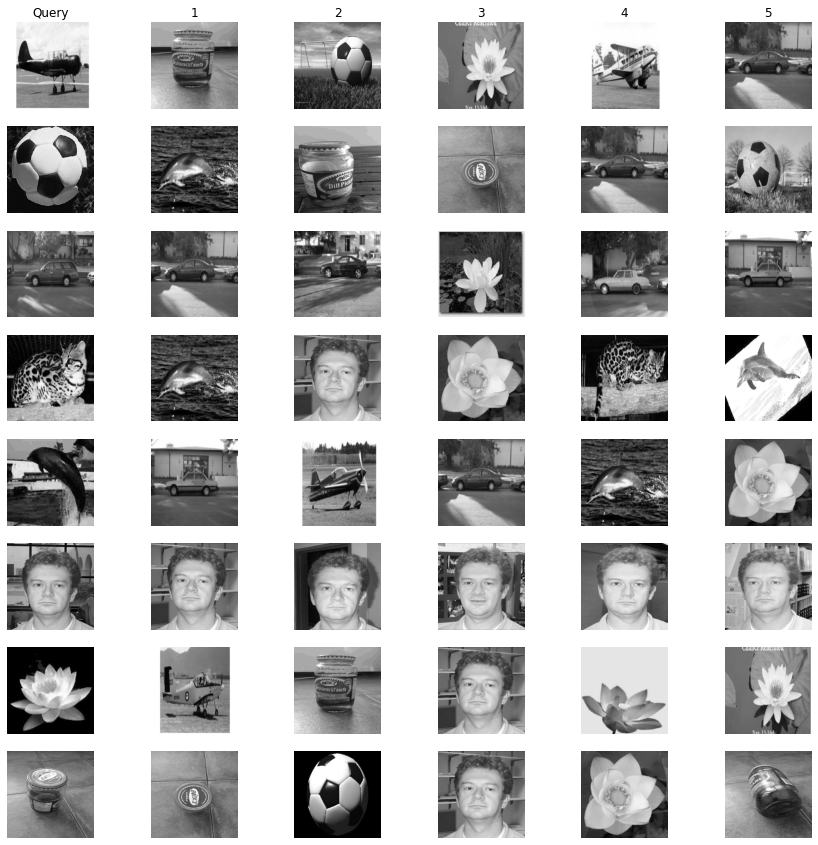

In [66]:
fig = plt.figure(figsize=[15, 15])
rows = 8
columns = 6
current_subplot = 0

for current_row in range(8):
    current_subplot += 1
    fig.add_subplot(rows, columns, current_subplot)
    plt.imshow(query_all[current_row], cmap='gray')
    plt.axis("off")
    if current_row == 0 :
        plt.title("Query")

    for i in range(5):
        current_subplot += 1
        fig.add_subplot(rows, columns, current_subplot)
        plt.imshow(images[sorted_images_all[current_row][i]], cmap='gray')
        plt.axis("off")
        
        if current_row == 0 :
            plt.title(i+1)